In [53]:
### Get comments by using Facebook API ###
import facebook
import requests

### Cleaning the comments using nltk ###
import re
import nltk
#nltk.download('stopwords') # Uncomment to download stopwords
from nltk.corpus import stopwords
from nltk.stem.snowball import SpanishStemmer

### Cleaning the comments using Freeling ###
from lxml import etree
from pyfreeling import Analyzer
config_file = '/usr/share/freeling/config/es.cfg'

### Create Bag of Words model ###
from sklearn.feature_extraction.text import CountVectorizer

### Create Bag of Words model ###
from sklearn.feature_extraction.text import CountVectorizer

### Web Scrapping ###
from bs4 import BeautifulSoup

### Saving data ###
import os

Tokken = 'EAACEdEose0cBABpTNoTOTmQ1T8z2PpqmlRkFz5FrrnjwFbfcviNTr5ZC7wz5PTLsYZAzGcgMHc3hj5K4mp0b7vccIXIWx9YE6V7CbirA5SVn4pq08ZAWhHhFz31VIH8qUFXQ7JuHkaAAbsI4DfEVZBdayFAHiuFFamH5apuxqaoMpywgigZCsIqBPqfU2gjpEFMo5BiktYgZDZD'


def get_id_link(id='prensalibregt/posts?'):
    access_token = Tokken
    graph = facebook.GraphAPI(access_token)
    post = graph.get_object(id=id, fields='link')
    
    id_news = []
    link_news = []
    
    for posts in post['data']:
        id_news.append(posts['id'])
        link_news.append(posts['link'])
    return [id_news,  link_news] 


def get_facebook_comments(news_id):
    comments = get_comments(news_id)
    corpus = clean_comments(comments)
    corpus_freeling = freeling_clean(corpus)
    corpus_correction = word_correction(corpus_freeling)
    words = bag_of_words(corpus_correction, max_features = 10)
    return [comments, corpus_correction, words]


def get_comments(news_id):
    # Facebook Access Token: https://developers.facebook.com/tools/explorer/
    access_token = Tokken

    user = '/me'
    graph = facebook.GraphAPI(access_token)
    profile = graph.get_object(user)

    # Testing with Prensa Libre's posts
    posts = graph.get_connections(id =news_id, connection_name='comments')
 
    comments = []
    while True:
        try:
            for post in posts['data']:
                comments.append(post['message'])
            posts = requests.get(posts['paging']['next']).json()
        except KeyError:
            break
    
    return comments


def clean_comments(comments):
    corpus = []
    for i in range(0,len(comments)):
        review = re.sub('[^a-zñA-ZÑáéíóúÁÉÍÓÚÜ]', ' ', comments[i])
        review = remove_emojis(review)
        #review = comments[i]
        review = review.lower()
        review = review.split()
        #stemmer = SpanishStemmer()
        #review = [stemmer.stem(word) for word in review if not word in set(stopwords.words('spanish'))]
        review = [word for word in review if not word in set(stopwords.words('spanish'))]
        review = ' '.join(review)
        corpus.append(review)
        
    return corpus


def remove_emojis(word):
    NON_BMP_RE = re.compile(u"[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]", flags=re.UNICODE)
    return NON_BMP_RE.sub(u'', word)


def freeling_clean(comments):
    corpus = []
    review = []
    
    analyzer = Analyzer(config=config_file, lang='es')
    for comment in comments:                  
        output = analyzer.run(comment.encode("utf_8"), 'flush')
        for i in output.iter():
            if 'lemma' in i.attrib:
                #print(i.attrib['lemma'])
                review.append(i.attrib['lemma'])
                
        
    corpus = review        
    return corpus


def word_correction(words):    
    words_dict = {"\\xc3\\xa1":'á', "\\xc3\\xa9":'é', "\\xc3\\xad":'í',\
                  "\\xc3\\xb3":'ó', "\\xc3\\xba":'ú', "\\xc3\\xbc":'ü',\
                 "\\xc3\\xb1":'ñ'}

    top_words = []
    for word in words:
        for entry in words_dict:
            if(word.find(entry)>0):
                word = (word.replace(entry, words_dict[entry]))
                break
        top_words.append(word)
    
    return top_words


def bag_of_words(corpus, max_features = 5):
    cv = CountVectorizer(max_features = max_features)
    X = cv.fit_transform(corpus).toarray()
    return cv.get_feature_names() 


def getNoticia(url):
    # Capturamos la url ingresada en la variable "url"
    url = url
    r  = requests.get(url)
    data = r.text
    
    # Creamos el objeto soup y le pasamos lo capturado con request
    soup = BeautifulSoup(data, "html.parser")

    #aqui se toman los articulos extra de prensalibre para removerlos al final y dejar solo la noticia de interes
    articles = soup.find_all('article', {'class' : 'story related gi'})
    numArticulos = 0
    for article in articles:
        numArticulos+=1

    # Find all of the text between paragraph tags and strip out the html
    parrafos = soup.find_all('p', {'class' : ''})
    listaParrafos = []
    for parrafo in parrafos:
        listaParrafos.append(parrafo.getText())


    #obtener solo los parrafos de contenido relevante (no noticias adicionales, publicidad, etc...)
    limiteSinArticulos = len(listaParrafos)- numArticulos#len(listaArticulos)
    cadena = ""
    for i in range(0,limiteSinArticulos):
        cadena += listaParrafos[i]
    return cadena

def get_News(url):
    listNews = []
    news = getNoticia(url)
    listNews.append(news)
    corpus = clean_comments(listNews)
    
    
    corpus_freeling = freeling_clean(corpus)
    corpus_correction = word_correction(corpus_freeling)
    
    words = bag_of_words(corpus_correction, max_features = 10)
    return [listNews, corpus_correction, words]


### Auxiliary function for making array of words ###
def palabraComentario (lista1, lista2):
    listaT = []
    for p in lista1:
        for c in lista2:
            listaT.append([p,c])
    return listaT


### Auxiliary functions for plotting ###
def dispersion_plot(corpus, words):
    tokens = []
    for word in corpus:
        tokens = tokens + nltk.word_tokenize(word)
    text = nltk.Text(tokens)
    text.dispersion_plot(words)
    return

def frequency_plot(corpus, words):
    tokens = []
    for word in corpus:
        tokens = tokens + nltk.word_tokenize(word)
    text = nltk.Text(tokens)
    fd = nltk.FreqDist(text)
    fd.plot(11,cumulative=False)
    return

### Auxiliary function for saving data ###
def save_data(file, data):
    file = open(file, "w")
    for e in data:
        file.write(e[0] + "," + e[1] + os.linesep)
    file.close()

In [49]:
[id_news, link_news] = get_id_link()

i = 0
for news,link in zip(id_news, link_news):
    print(i, news, link)
    i += 1
#print(id_news[6], link_news[6])

0 345419408148_10155869674503149 http://www.prensalibre.com/guatemala/politica/asi-estan-las-negociaciones-para-elegir-la-junta-directiva-en-el-congreso
1 345419408148_10155869276833149 http://bit.ly/2AsfVku
2 345419408148_10155869544903149 http://www.prensalibre.com/guatemala/comunitario/piatas-de-jimmy-morales-arderan-en-la-quema-del-diablo
3 345419408148_10155869471438149 http://www.prensalibre.com/deportes/deporte-nacional/gonzalez-se-requiere-mucha-dedicacion-y-entrenamiento-para-ganar-a-uno-de-oro
4 345419408148_10155869248603149 http://bit.ly/2BKMiJt
5 345419408148_10155869371723149 http://www.prensalibre.com/PrensaLibreTV/guatemala/encapuchados-asaltan-a-ciclistas-en-plena-competencia
6 345419408148_10155869222563149 http://bit.ly/2jSxdxt
7 345419408148_10155869236618149 http://bit.ly/2BLZfTt
8 345419408148_10155869254548149 http://bit.ly/2nxaQT0
9 345419408148_10155869200463149 http://bit.ly/2ASw2bD
10 345419408148_10155869004513149 http://bit.ly/2iSy5pd
11 345419408148_101558

In [50]:
[facebook_comments, facebook_corpus, facebook_words] = get_facebook_comments(id_news[19])

[news_comments, news_corpus, news_words] = get_News(link_news[19])

data = palabraComentario (facebook_words, news_words)
save_data("data.txt", data)

In [51]:
print("Estas son las palabras extraídas de los comentarios  de Facebook: ")
#print(facebook_comments)
#print(facebook_corpus)
print(facebook_words)

print("\n Estas son las palabras extraídas de las noticias: ")
#print(news_comments)
#print(news_corpus)
print(news_words)

Estas son las palabras extraídas de los comentarios  de Facebook: 
['admirar', 'cristiano', 'hijo', 'mejor', 'mes_si', 'niño', 'papa', 'papá', 'saber', 'si']

 Estas son las palabras extraídas de las noticias: 
['además', 'astro', 'cristiano', 'gracia', 'libre', 'madrid', 'mensaje', 'nivel', 'ocasión', 'publicación']


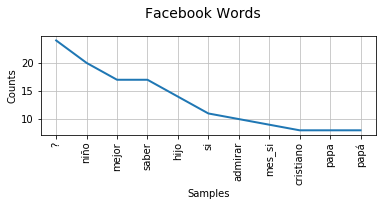

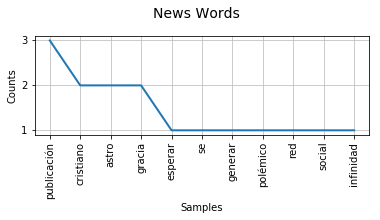

In [54]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.suptitle("Facebook Words", size=14)
frequency_plot(facebook_corpus, facebook_words)

plt.subplot(2, 1, 1)
plt.suptitle("News Words", size=14)
frequency_plot(news_corpus, news_words)